# Kaggle_Titanic_Assignment

## 전처리 -> Logistic Regression &Metric  -> Naive Bayesian & Metric -> ROC Curve

In [248]:

### 0. 패키지 불러오기 & 데이터 프레임 불러오기


#패키지 불러오기
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  linear_model
from sklearn import  preprocessing
from pandas.plotting import scatter_matrix


## 전처리

In [249]:
# Train - dataset 데이터 프레임 정의
data_url ='titanic_train.csv'
df_all=pd.read_csv(data_url, header = 'infer')
load_train = pd.read_csv('train.csv')

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

#### 데이터의 경우, Y값이 존재해야 roc curve를 판단할 수 있기 때문에 Y값이 존재하는 train 데이터 셋을 불러온 뒤 이를 분할하여 사용할 목적으로 train 데이터 셋만 불러옴

In [250]:
df_all.shape

(891, 12)

In [251]:
# Y 값 (목적값) 을 따로 빼서 정리 del 보다 번거롭지 않아서 pop이 좋은듯.
y_data = df_all.pop("Survived")
y_data.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [252]:
# 결측치가 존재하는 행 순서대로 나타내기.

df_all.isnull().sum().sort_values(ascending=False).head()

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
dtype: int64

### 결측치가 높은 데이터와 기타 피쳐 전처리

 Cabin = 	Cabin number 선실 번호
 -> 선실 배치에 대한 정보가 없기 때문에 해석이 무의미하며 결측치도 많기 때문에 소거 처리 

 Age = 	Age in years 나이
 Age 특징 = Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
 -> 평균값으로 대체

 Embarked = 	Port of Embarkation 태운 항구
 -> 수치도 2 정도로 작기 때문에 최빈값으로 대체

 Fare = 	Passenge fare 요금
 -> 평균값으로 대체
 
 PassengerId
 ->인덱스 값이기 때문에 소거 처리
 
 Name = 승객명
 -> 승객명은 무의미한 정보고 피쳐수가 상당히 증가하기 때문에 혼인 여부를 가늠할 수 있는 mrs, mr정도만 남긴다.




In [253]:
#list_name = df_all['Name'].values().asmatrix
#for i in list_name:
#    if 'Mr.' in i :
#        load_train.Name[i] = 'Mr.'
#    elif 'Miss.' in i :
#        load_train.Name[i] = 'Miss'
#    elif 'Mrs.' in i :
#        load_train.Name[i] = 'Mrs'
#    elif 'Master.' in i :
#        load_train.Name[i] = 'Master'
#    else :
#        load_train.Name[i] = 'nothing'

#list_name



In [254]:

# 승객명은 불필요한 정보지만 Mr, Miss, Mrs, Master 혼인여부는 유의미한 정보이기 때문에 변환. 
# (코드는 혼자 이것저것 해보다 김재영 학생의 코드를 참고했으나 잘 안되서 일단은 다 해당 컬럼을 지워버렸습니다.)
# (더 해보고 다음 시간 이전까지 나이브 베이지안 과제와 같이 다시 제출하도록 해보겠습니다.)
'''
for i in range(len(df_all.Name)):
    a = df_all.Name[i].split()
    if 'Mr.' in a :
        df_all.Name[i] = 'Mr.'
    elif 'Miss.' in a :
        df_all.Name[i] = 'Miss'
    elif 'Mrs.' in a :
        df_all.Name[i] = 'Mrs'
    elif 'Master.' in a :
        df_all.Name[i] = 'Master'
    else :
        df_all.Name[i] = 'nothing'
        '''

# 태운 항구는 최빈값으로 대체
a = df_all["Embarked"].value_counts()[0]
df_all["Embarked"] = df_all["Embarked"].fillna(a)

# 요금은 평균값으로 대체
df_all["Fare"] = df_all["Fare"].fillna(df_all["Fare"].mean())

# 나이는 평균값으로 대체 
df_all["Age"] = df_all["Fare"].fillna(df_all["Age"].mean()  )

# 해당 특성이 너무 많지만 무의미한 'Ticket', 인덱스를 나타내는 'Passengerld', 무의미하면서 결측치가 높은 'Cabin' 드랍
after_data = df_all.drop(['Ticket','PassengerId','Cabin','Name'],axis=1)




In [255]:
df_all = pd.get_dummies(df_all)


In [256]:
from sklearn.model_selection import train_test_split

# Train, Test 데이터 분할

# id 컬럼을 제외한 1459번 까지의 row를 train 값으로 편성
x_train = df_all.iloc[:891,0:].as_matrix()
# id 컬럼을 제외한 1459번 부터의 row를 test 값으로 편성
x_test = df_all.iloc[891:,0:].as_matrix()
y_train = y_data.as_matrix()

x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size =0.2, random_state=22)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((712, 1731), (712,), (179, 1731), (179,))

In [257]:
from sklearn.preprocessing import LabelEncoder

# 자동으로 M ,B 따위의 카테고리 데이터를 1과 0 으로 표현해줌
le = LabelEncoder()
y_train = le.fit_transform(y_train)

## Logistic Regression  & Metric

In [258]:
#Logistic Regression에 대입 후 파라미터 도출

Lr = LogisticRegression()
Lr.fit(x_train, y_train)

print ('Coefficients:',regr.coef_)
print ('intercept:',regr.intercept_)

Coefficients: [ -1.28597403e-01   9.62381811e-05  -2.95092576e-02  -2.13326925e-02
   9.62381811e-05   2.76908512e-01  -2.76908512e-01   2.83561770e-02
   3.85067070e-02  -2.36845161e-02  -4.31783678e-02]
intercept: 0.807934605138


In [259]:
from sklearn.metrics import classification_report
print (classification_report(y_test, Lr.predict(x_test)))

             precision    recall  f1-score   support

          0       0.79      0.84      0.81       110
          1       0.71      0.65      0.68        69

avg / total       0.76      0.77      0.76       179



##  Naive Bayesian & Metric

In [260]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB


mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

mnb.fit(x_train, y_train)
bnb.fit(x_train, y_train)
gnb.fit(x_train, y_train)


GaussianNB(priors=None)

In [261]:
from sklearn.metrics import classification_report
print (classification_report(y_test, mnb.predict(x_test)))

             precision    recall  f1-score   support

          0       0.68      0.74      0.71       110
          1       0.52      0.45      0.48        69

avg / total       0.62      0.63      0.62       179



In [262]:
from sklearn.metrics import classification_report
print (classification_report(y_test, bnb.predict(x_test)))

             precision    recall  f1-score   support

          0       0.78      0.81      0.79       110
          1       0.68      0.64      0.66        69

avg / total       0.74      0.74      0.74       179



In [263]:
from sklearn.metrics import classification_report
print (classification_report(y_test, gnb.predict(x_test)))

             precision    recall  f1-score   support

          0       0.86      0.22      0.35       110
          1       0.43      0.94      0.59        69

avg / total       0.69      0.50      0.44       179



##  ROC Curve

#### 다양한 MinMax와 Standard 스케일러가 각각 처리했을때 차이가 있는 지 궁금해서 해봤으나 크게 차이는 없는 듯 하네요..

In [264]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline(steps=[('scl',MinMaxScaler()), ('clf',LogisticRegression())])
pipe_lr.fit(X = x_train, y = y_train)

pipe_rf = Pipeline(steps=[('scl',StandardScaler()),('clf',LogisticRegression())])
pipe_rf.fit(X=x_train,y=y_train)

pipe_mmnb = Pipeline(steps=[('scl',MinMaxScaler()), ('clf',MultinomialNB())])
pipe_mmnb.fit(X = x_train, y = y_train)

pipe_mbnb = Pipeline(steps=[('scl',MinMaxScaler()),('clf',BernoulliNB())])
pipe_mbnb.fit(X=x_train,y=y_train)

pipe_sbnb = Pipeline(steps=[('scl',StandardScaler()),('clf',BernoulliNB())])
pipe_sbnb.fit(X=x_train,y=y_train)

pipe_mgnb = Pipeline(steps=[('scl',MinMaxScaler()),('clf',GaussianNB())])
pipe_mgnb.fit(X=x_train,y=y_train)

pipe_sgnb = Pipeline(steps=[('scl',StandardScaler()),('clf',GaussianNB())])
pipe_sgnb.fit(X=x_train,y=y_train)

print ("MinMaxScaler - LogisticRegression")
print (pipe_lr.score(x_test,y_test))
print ("StandardScaler - LogisticRegression")
print (pipe_rf.score(x_test,y_test))
print ("MinMaxScaler - MultinomialNB")
print (pipe_mmnb.score(x_test,y_test))
print ("MinMaxScaler - BernoulliNB")
print (pipe_mbnb.score(x_test,y_test))
print ("StandardScaler - BernoulliNB")
print (pipe_sbnb.score(x_test,y_test))
print ("MinMaxScaler - GaussianNB")
print (pipe_mgnb.score(x_test,y_test))
print ("StandardScaler - GaussianNB")
print (pipe_sgnb.score(x_test,y_test))

MinMaxScaler - LogisticRegression
0.765363128492
StandardScaler - LogisticRegression
0.765363128492
MinMaxScaler - MultinomialNB
0.776536312849
MinMaxScaler - BernoulliNB
0.759776536313
StandardScaler - BernoulliNB
0.798882681564
MinMaxScaler - GaussianNB
0.497206703911
StandardScaler - GaussianNB
0.491620111732


In [265]:
#왼쪽은 파산이 안날 확률 오른쪽은 1일 확률
pipe_lr.predict_proba(x_test)

array([[ 0.32567335,  0.67432665],
       [ 0.58177766,  0.41822234],
       [ 0.87519939,  0.12480061],
       [ 0.33975644,  0.66024356],
       [ 0.13194024,  0.86805976],
       [ 0.85094107,  0.14905893],
       [ 0.07672287,  0.92327713],
       [ 0.91448796,  0.08551204],
       [ 0.91202263,  0.08797737],
       [ 0.08434247,  0.91565753],
       [ 0.3431708 ,  0.6568292 ],
       [ 0.32332862,  0.67667138],
       [ 0.95956295,  0.04043705],
       [ 0.91200397,  0.08799603],
       [ 0.33330407,  0.66669593],
       [ 0.9587427 ,  0.0412573 ],
       [ 0.1300161 ,  0.8699839 ],
       [ 0.65481885,  0.34518115],
       [ 0.06019652,  0.93980348],
       [ 0.9004344 ,  0.0995656 ],
       [ 0.30996344,  0.69003656],
       [ 0.97036713,  0.02963287],
       [ 0.19505586,  0.80494414],
       [ 0.90678527,  0.09321473],
       [ 0.90950687,  0.09049313],
       [ 0.90613779,  0.09386221],
       [ 0.90628678,  0.09371322],
       [ 0.38303345,  0.61696655],
       [ 0.05049978,

In [266]:
#1일 확률만 필요하니까 뽑는 것.
pipe_lr_scores = pipe_lr.predict_proba(x_test)[:,1]
pipe_rf_scores = pipe_rf.predict_proba(x_test)[:,1]
pipe_mmnb_scores = pipe_mmnb.predict_proba(x_test)[:,1]
pipe_mbnb_scores = pipe_mbnb.predict_proba(x_test)[:,1]
pipe_sbnb_scores = pipe_sbnb.predict_proba(x_test)[:,1]
pipe_mgnb_scores = pipe_mgnb.predict_proba(x_test)[:,1]
pipe_sgnb_scores = pipe_sgnb.predict_proba(x_test)[:,1]

y_real = y_test

In [267]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pipe_lr_scores Predict
scores= pipe_lr.predict_proba(x_test)[:,1]
fpr_lr, tpr_lr, thresholds = roc_curve(y_real, scores)
roc_auc_lr = roc_auc_score(y_real,scores)

# pipe_rf_scores Predict
scores= pipe_rf.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_rf = roc_auc_score(y_real,scores)

# pipe_mmnb_scores Predict
scores= pipe_mmnb.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_mmnb = roc_auc_score(y_real,scores)

# pipe_mbnb_scores Predict
scores= pipe_mbnb.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_mbnb = roc_auc_score(y_real,scores)

# pipe_sbnb_scores Predict
scores= pipe_sbnb.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_sbnb = roc_auc_score(y_real,scores)

# pipe_mgnb_scores Predict
scores= pipe_mgnb.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_mgnb = roc_auc_score(y_real,scores)

# pipe_sgnb_scores Predict
scores= pipe_sgnb.predict_proba(x_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_real, scores)
roc_auc_sgnb = roc_auc_score(y_real,scores)


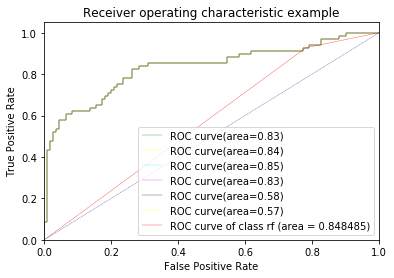

In [268]:
import matplotlib.pyplot as plt

plt.figure()
lw=0.3
plt.plot(fpr_lr, tpr_lr, color='green',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_lr)
plt.plot(fpr_lr, tpr_lr, color='yellow',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_mmnb)
plt.plot(fpr_lr, tpr_lr, color='cyan',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_mbnb)
plt.plot(fpr_lr, tpr_lr, color='magenta',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_sbnb)
plt.plot(fpr_lr, tpr_lr, color='black',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_mgnb)
plt.plot(fpr_lr, tpr_lr, color='yellow',lw=lw,label='ROC curve(area=%0.2f)' %roc_auc_sgnb)
plt.plot(fpr_rf, tpr_rf, color='red',lw=lw,label='ROC curve of class {0} (area = {1:02f})' ''.format("rf",roc_auc_rf))


plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()